In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.path as mpath
import matplotlib.patches as patches
import matplotlib.cm as cm
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cartopy.mpl.gridliner as gridliner
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
%matplotlib inline
import time
import cftime
import seaborn as sns
from scipy.signal import detrend

In [2]:
plt.rc('font', size=17)          # controls default text sizes
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

In [3]:
path='/Users/thomas/Downloads/TSA/CESM1.3-HR/'

In [4]:
cesm_hr_hist_ds=xr.open_dataset(path+'TSA_hist.nc').drop_vars('time_bnds')
cesm_hr_proj_ds=xr.open_dataset(path+'TSA_proj.nc').drop_vars('time_bnds')

### Shifting Data

In [5]:
def shift_month(ds):
    ds = ds.copy()
    time_as_pd_datetime = []
    
    for date in ds['time'].values:
        # Skip specific years 2469 and 1849
        if date.year in [2469, 1849]:
            continue
        
        try:
            # Attempt to convert to pandas Timestamp
            pd_date = pd.Timestamp(date.year, date.month, date.day)
        except pd._libs.tslibs.np_datetime.OutOfBoundsDatetime:
            # If out of bounds, convert using cftime
            pd_date = cftime.DatetimeNoLeap(date.year, date.month, date.day)
        time_as_pd_datetime.append(pd_date)
    
    # Subtract one month using cftime where necessary
    shifted_dates = [
        (pd_date - pd.DateOffset(months=1) if isinstance(pd_date, pd.Timestamp) 
         else cftime.DatetimeNoLeap(pd_date.year, pd_date.month - 1 if pd_date.month > 1 else 12, pd_date.day, pd_date.hour, pd_date.minute, pd_date.second))
        for pd_date in time_as_pd_datetime
    ]
    
    # Create a boolean mask for dates within the desired range
    valid_mask = [date.year not in [2469, 1849] for date in shifted_dates]
    
    # Apply the mask to filter the dataset
    filtered_ds = ds.isel(time=[i for i, valid in enumerate(valid_mask) if valid])
    filtered_ds['time'] = [date for date in shifted_dates if date.year not in [2469, 1849]]
    
    return filtered_ds

In [6]:
cesm_hr_hist_shift=shift_month(cesm_hr_hist_ds)
cesm_hr_proj_shift=shift_month(cesm_hr_proj_ds)
cesm_hr_hist=cesm_hr_hist_shift.sel(time=slice('1850','2005'))
cesm_hr_proj=cesm_hr_proj_shift.sel(time=slice('2006','2101'))   

### Data checks

In [7]:
def count_months_per_year(ds):
    # Extract the time dimension
    times = ds['time'].values
    
    # Create a dictionary to count months for each year
    year_month_count = {}
    
    for date in times:
        # Convert numpy.datetime64 to pandas Timestamp
        if isinstance(date, np.datetime64):
            date = pd.Timestamp(date)
        # Convert cftime.DatetimeNoLeap to pandas Timestamp (if needed)
        elif isinstance(date, cftime.DatetimeNoLeap):
            date = pd.Timestamp(str(date))
        
        year = date.year
        month = date.month
        
        if year not in year_month_count:
            year_month_count[year] = set()
        
        year_month_count[year].add(month)
    
    # Create a summary of counts
    summary = {year: len(months) for year, months in year_month_count.items()}
    
    return summary

# Example usage with your dataset
cesm_hr_hist_summary = count_months_per_year(cesm_hr_proj_shift)

# Print the summary
for year, month_count in sorted(cesm_hr_hist_summary.items()):
    if month_count < 12:
        print(f"{year}: {month_count}")

2062: 5
2068: 1
2102: 2


### Coastal Areas

In [8]:
nain_lon=298.31 #-61.69
nain_lat=56.54 

hope_lon=299.79 # -60.21
hope_lat=55.45 

post_lon=300.23 # -59.77
post_lat=54.91 

rigo_lon=301.58 # -58.42
rigo_lat=54.17 

In [9]:
def sel_region (lon_value,lat_value, ds):
    # Find the nearest index for the target lat value
    lat_diff = np.abs(ds['lat'] - lat_value)
    lon_diff = np.abs(ds['lon'] - lon_value)

    # Create a combined metric to find the best matching point
    combined_diff = lat_diff + lon_diff

    # Get the index of the minimum combined difference
    closest_idx = combined_diff.argmin(dim='x').values

    # Use isel to select the data at the found index
    selected_ds = ds.isel(x=closest_idx)
    
    return selected_ds

In [10]:
#nain
nain_cesm_hist=sel_region(nain_lon, nain_lat,cesm_hr_hist)
nain_cesm_proj=sel_region(nain_lon, nain_lat,cesm_hr_proj)
nain_cesm_hist_celsius=nain_cesm_hist-273.15
nain_cesm_proj_celsius=nain_cesm_proj-273.15
nain_cesm=xr.concat([nain_cesm_hist_celsius,nain_cesm_proj_celsius], dim='time').fillna(0)

#hope
hope_cesm_hist=sel_region(hope_lon, hope_lat,cesm_hr_hist)
hope_cesm_proj=sel_region(hope_lon, hope_lat,cesm_hr_proj)
hope_cesm_hist_celsius=hope_cesm_hist-273.15
hope_cesm_proj_celsius=hope_cesm_proj-273.15
hope_cesm=xr.concat([hope_cesm_hist_celsius,hope_cesm_proj_celsius], dim='time').fillna(0)

#post
post_cesm_hist=sel_region(post_lon, post_lat,cesm_hr_hist)
post_cesm_proj=sel_region(post_lon, post_lat,cesm_hr_proj)
post_cesm_hist_celsius=post_cesm_hist-273.15
post_cesm_proj_celsius=post_cesm_proj-273.15
post_cesm=xr.concat([post_cesm_hist_celsius,post_cesm_proj_celsius], dim='time').fillna(0)

#rigo
rigo_cesm_hist=sel_region(rigo_lon, rigo_lat,cesm_hr_hist)
rigo_cesm_proj=sel_region(rigo_lon, rigo_lat,cesm_hr_proj)
rigo_cesm_hist_celsius=rigo_cesm_hist-273.15
rigo_cesm_proj_celsius=rigo_cesm_proj-273.15
rigo_cesm=xr.concat([rigo_cesm_hist_celsius,rigo_cesm_proj_celsius], dim='time').fillna(0)

In [11]:
# Define the dates to modify
dates_to_modify = [np.datetime64('1930-01-01'), np.datetime64('1930-02-01'), np.datetime64('1930-05-01')]

# Multiply the values for the specified dates by -1
for date in dates_to_modify:
    if date in nain_cesm.time.values:
        nain_cesm.loc[dict(time=date)] *= -1
        
# Multiply the values for the specified dates by -1
for date in dates_to_modify:
    if date in hope_cesm.time.values:
        hope_cesm.loc[dict(time=date)] *= -1
        
# Multiply the values for the specified dates by -1
for date in dates_to_modify:
    if date in post_cesm.time.values:
        post_cesm.loc[dict(time=date)] *= -1
        
# Multiply the values for the specified dates by -1
for date in dates_to_modify:
    if date in rigo_cesm.time.values:
        rigo_cesm.loc[dict(time=date)] *= -1

### Finding the cummulative FDD

In [12]:
def fdd_calculation(y1, y2, data):
    def calculate_fdd_for_season(year, ds=data):
        # Select the relevant time range for the given year
        start_date = f'{year}-11-01'
        end_date = f'{year + 1}-09-01'
        season_data = ds.sel(time=slice(start_date, end_date))

        # Assuming the temperature data is in a variable named 'temperature'
        TSA = season_data['TSA'].values
        dates = season_data['time'].values

        # Create a DataFrame for easier manipulation
        data = pd.DataFrame({
            'date': dates,
            'TSA': TSA
        })

        # Calculate the number of days in each month, without considering leap years
        data['date'] = pd.to_datetime(data['date'])
        days_in_month = {11: 30, 12: 31, 1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7:30, 8: 31, 9: 30}
        data['days_in_month'] = data['date'].dt.month.map(days_in_month)

        # Calculate FDD for each month
        data['fdd'] = data.apply(lambda row: max(0, -row['TSA']) * row['days_in_month'], axis=1)

        # Calculate cumulative FDD
        data['cumulative_fdd'] = data['fdd'].cumsum()

        return data

    # List of years for which we want to calculate FDD
    years = range(y1, y2)

    # Calculate FDD for each year and store the results
    fdd_results = {}
    for year in years:
        fdd_results[year] = calculate_fdd_for_season(year)
    
    return fdd_results, calculate_fdd_for_season

    # Display the results for each year
    # for year, result in fdd_results.items():
        #print(f"FDD for the ice season {year}")
        #print(result[['date', 'temperature', 'days_in_month', 'fdd', 'cumulative_fdd']])
        #print()

In [13]:
#nain
nain_fdd_results_1850_2061, nain_calculate_fdd_for_season_1850_2061 = fdd_calculation(1850,2062, nain_cesm)
nain_fdd_results_2068_2100, nain_calculate_fdd_for_season_2068_2100 = fdd_calculation(2068,2101, nain_cesm)

#hope
hope_fdd_results_1850_2061, hope_calculate_fdd_for_season_1850_2061 = fdd_calculation(1850,2062, hope_cesm)
hope_fdd_results_2068_2100, hope_calculate_fdd_for_season_2068_2100 = fdd_calculation(2068,2101, hope_cesm)

#post
post_fdd_results_1850_2061, post_calculate_fdd_for_season_1850_2061 = fdd_calculation(1850,2062, post_cesm)
post_fdd_results_2068_2100, post_calculate_fdd_for_season_2068_2100 = fdd_calculation(2068,2101, post_cesm)

#rigo
rigo_fdd_results_1850_2061, rigo_calculate_fdd_for_season_1850_2061 = fdd_calculation(1850,2062, rigo_cesm)
rigo_fdd_results_2068_2100, rigo_calculate_fdd_for_season_2068_2100 = fdd_calculation(2068,2101, rigo_cesm)

### Finding the Onset date

In [14]:
def ice_onset(y1, y2, df, func):
    def find_start_of_season(data=df, target_fdd=500):
        for i in range(1, len(data)):
            if data['cumulative_fdd'].iloc[i] >= target_fdd:
                fdd1 = data['cumulative_fdd'].iloc[i-1]
                day1 = 1  # Start of the month
                fdd2 = data['cumulative_fdd'].iloc[i]
                day2 = data['days_in_month'].iloc[i-1]
                # Linear interpolation formula
                interpolated_day = day1 + ((target_fdd - fdd1) / (fdd2 - fdd1)) * (day2 - day1)
                start_date = pd.Timestamp(data['date'].iloc[i-1]).replace(day=round(interpolated_day))
                return start_date
        return None

    # List of years for which we want to calculate FDD
    years = range(y1, y2)

    season_starts = {}
    for year in years:
        season_data = func(year)
        season_starts[year] = find_start_of_season(season_data)
    
    return season_starts

### Finding the Cessation date

In [15]:
def ice_cessation(y1, y2, df, func):
    def find_end_of_season(data=df, target_temp=0):
        for i in range(1, len(data)):
            if data['TSA'].iloc[i-1] <= target_temp <= data['TSA'].iloc[i]:
                temp1 = data['TSA'].iloc[i-1]
                day1 = 1  # Start of the month
                temp2 = data['TSA'].iloc[i]
                day2 = data['days_in_month'].iloc[i-1]

                # Check if the exact temperature is 0
                if temp1 == target_temp:
                    return pd.Timestamp(data['date'].iloc[i-1]).replace(day=day1)
                if temp2 == target_temp:
                    return pd.Timestamp(data['date'].iloc[i]).replace(day=1)
                
                # Linear interpolation formula
                interpolated_day = day1 + ((target_temp - temp1) / (temp2 - temp1)) * (day2 - day1)
                end_date = pd.Timestamp(data['date'].iloc[i-1]).replace(day=int(round(interpolated_day)))
                return end_date
        return None


    # List of years for which we want to calculate FDD
    years = range(y1, y2)

    # Calculate FDD for each ice season and store the results
    season_ends = {}
    for year in years:
        season_data = func(year)
        season_ends[year] = find_end_of_season(season_data)
        
    return season_ends

In [16]:
# Nain
nain_season_starts_1850_2061 = ice_onset(1850, 2062, nain_fdd_results_1850_2061, nain_calculate_fdd_for_season_1850_2061)
nain_season_starts_2068_2100 = ice_onset(2068, 2101, nain_fdd_results_2068_2100, nain_calculate_fdd_for_season_2068_2100)
nain_season_ends_1850_2061 = ice_cessation(1850, 2062, nain_fdd_results_1850_2061, nain_calculate_fdd_for_season_1850_2061)
nain_season_ends_2068_2100 = ice_cessation(2068, 2101, nain_fdd_results_2068_2100, nain_calculate_fdd_for_season_2068_2100)

# hope
hope_season_starts_1850_2061 = ice_onset(1850, 2062, hope_fdd_results_1850_2061, hope_calculate_fdd_for_season_1850_2061)
hope_season_starts_2068_2100 = ice_onset(2068, 2101, hope_fdd_results_2068_2100, hope_calculate_fdd_for_season_2068_2100)
hope_season_ends_1850_2061 = ice_cessation(1850, 2062, hope_fdd_results_1850_2061, hope_calculate_fdd_for_season_1850_2061)
hope_season_ends_2068_2100 = ice_cessation(2068, 2101, hope_fdd_results_2068_2100, hope_calculate_fdd_for_season_2068_2100)

# post
post_season_starts_1850_2061 = ice_onset(1850, 2062, post_fdd_results_1850_2061, post_calculate_fdd_for_season_1850_2061)
post_season_starts_2068_2100 = ice_onset(2068, 2101, post_fdd_results_2068_2100, post_calculate_fdd_for_season_2068_2100)
post_season_ends_1850_2061 = ice_cessation(1850, 2062, post_fdd_results_1850_2061, post_calculate_fdd_for_season_1850_2061)
post_season_ends_2068_2100 = ice_cessation(2068, 2101, post_fdd_results_2068_2100, post_calculate_fdd_for_season_2068_2100)

# rigo
rigo_season_starts_1850_2061 = ice_onset(1850, 2062, rigo_fdd_results_1850_2061, rigo_calculate_fdd_for_season_1850_2061)
rigo_season_starts_2068_2100 = ice_onset(2068, 2101, rigo_fdd_results_2068_2100, rigo_calculate_fdd_for_season_2068_2100)
rigo_season_ends_1850_2061 = ice_cessation(1850, 2062, rigo_fdd_results_1850_2061, rigo_calculate_fdd_for_season_1850_2061)
rigo_season_ends_2068_2100 = ice_cessation(2068, 2101, rigo_fdd_results_2068_2100, rigo_calculate_fdd_for_season_2068_2100)

### Ice season length

In [17]:
def ice_season_lengths(season_starts,season_ends):
    lengths = []

    for year in season_starts.keys():
        start_date = season_starts[year]
        end_date = season_ends.get(year)

        if end_date:
            season_length = (end_date - start_date).days + 1  # Inclusive of both start and end dates
            lengths.append((year, season_length))

    # Create a DataFrame
    df_ice_season_lengths = pd.DataFrame(lengths, columns=['Year', 'Ice_Season_Length'])
    
    return df_ice_season_lengths

In [18]:
#nain
nain_ice_season_lengths_1850_2061=ice_season_lengths(nain_season_starts_1850_2061,nain_season_ends_1850_2061)
nain_ice_season_lengths_2068_2100=ice_season_lengths(nain_season_starts_2068_2100,nain_season_ends_2068_2100)

#hope
hope_ice_season_lengths_1850_2061=ice_season_lengths(hope_season_starts_1850_2061,hope_season_ends_1850_2061)
hope_ice_season_lengths_2068_2100=ice_season_lengths(hope_season_starts_2068_2100,hope_season_ends_2068_2100)

#post
post_ice_season_lengths_1850_2061=ice_season_lengths(post_season_starts_1850_2061,post_season_ends_1850_2061)
post_ice_season_lengths_2068_2100=ice_season_lengths(post_season_starts_2068_2100,post_season_ends_2068_2100)

#rigo
rigo_ice_season_lengths_1850_2061=ice_season_lengths(rigo_season_starts_1850_2061,rigo_season_ends_1850_2061)
rigo_ice_season_lengths_2068_2100=ice_season_lengths(rigo_season_starts_2068_2100,rigo_season_ends_2068_2100)

### Visualization

(1850.0, 2100.0)

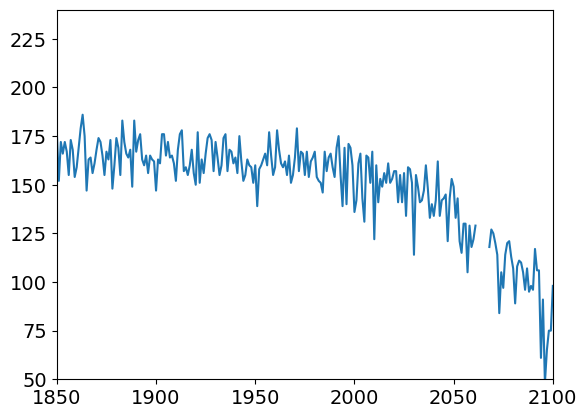

In [19]:
plt.plot(nain_ice_season_lengths_1850_2061['Year'],nain_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:blue')
plt.plot(nain_ice_season_lengths_2068_2100['Year'],nain_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:blue')
plt.ylim(50,240)
plt.xlim(1850,2100)

(1850.0, 2100.0)

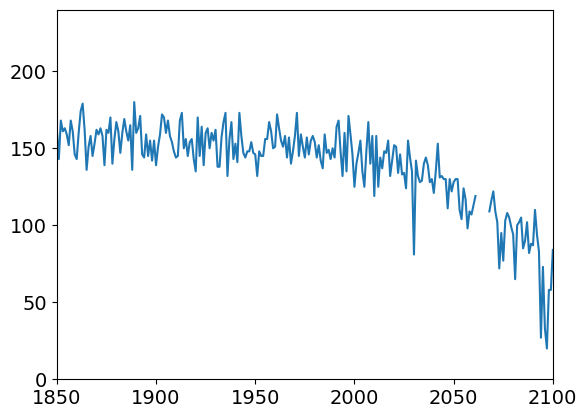

In [20]:
plt.plot(hope_ice_season_lengths_1850_2061['Year'],hope_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:blue')
plt.plot(hope_ice_season_lengths_2068_2100['Year'],hope_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:blue')
plt.ylim(0,240)
plt.xlim(1850,2100)

(1850.0, 2100.0)

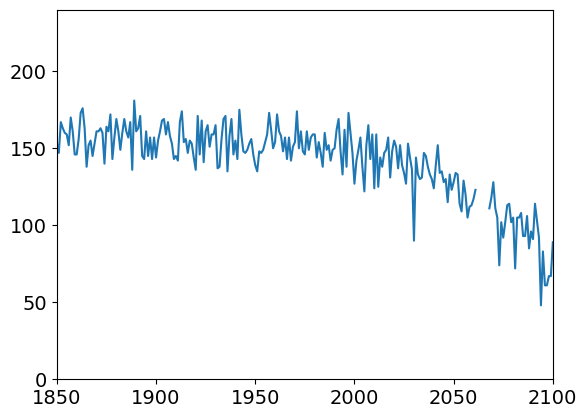

In [21]:
plt.plot(post_ice_season_lengths_1850_2061['Year'],post_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:blue')
plt.plot(post_ice_season_lengths_2068_2100['Year'],post_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:blue')
plt.ylim(0,240)
plt.xlim(1850,2100)

(1850.0, 2100.0)

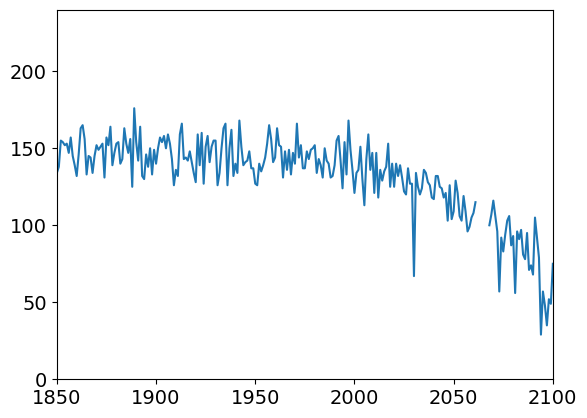

In [22]:
plt.plot(rigo_ice_season_lengths_1850_2061['Year'],rigo_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:blue')
plt.plot(rigo_ice_season_lengths_2068_2100['Year'],rigo_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:blue')
plt.ylim(0,240)
plt.xlim(1850,2100)

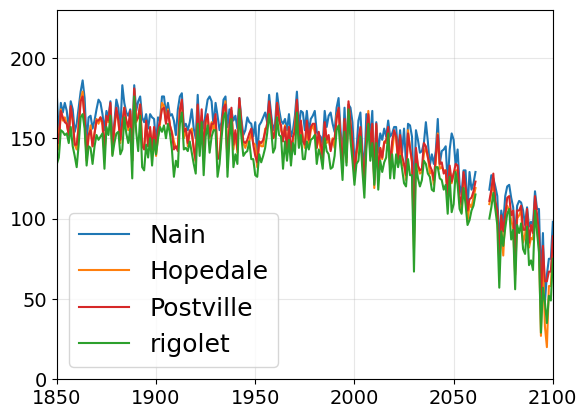

In [25]:
plt.plot(nain_ice_season_lengths_1850_2061['Year'],nain_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:blue', label='Nain')
plt.plot(nain_ice_season_lengths_2068_2100['Year'],nain_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:blue')

plt.plot(hope_ice_season_lengths_1850_2061['Year'],hope_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:orange', label='Hopedale')
plt.plot(hope_ice_season_lengths_2068_2100['Year'],hope_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:orange')

plt.plot(post_ice_season_lengths_1850_2061['Year'],post_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:red', label='Postville')
plt.plot(post_ice_season_lengths_2068_2100['Year'],post_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:red')

plt.plot(rigo_ice_season_lengths_1850_2061['Year'],rigo_ice_season_lengths_1850_2061['Ice_Season_Length'], color='tab:green', label='rigolet')
plt.plot(rigo_ice_season_lengths_2068_2100['Year'],rigo_ice_season_lengths_2068_2100['Ice_Season_Length'], color='tab:green')


plt.xlim(1850, 2100)
plt.ylim(0, 230)
plt.legend()
plt.grid(alpha=0.3)